In [1]:
!pip install catboost shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5830e023d10f95c5fbdbd1775ae0051950c4a305c7eb4f0093b129fe334de8db
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


#Libraries

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import ast
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
import shap
from lime.lime_tabular import LimeTabularExplainer
from catboost import CatBoostClassifier
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from scipy.stats import f_oneway
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')


Mounted at /content/drive


In [3]:
# Open and load the file from Drive
directory = '/content/drive/MyDrive/Colab Notebooks/Project/'


# file_path = directory + 'clean_data_mice_knn.xlsx'
file_path = directory + 'normalized_data.xlsx'

imputed_df = pd.read_excel(file_path)
imputed_df.info()
imputed_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Columns: 187 entries, Status to Val
dtypes: float64(185), int64(2)
memory usage: 137.5 KB


,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,1,1,0.135959,0.131794,0.026262,0.127203,0.275701,0.272440,0.083199,0.429530,...,0.646751,0.326418,0.339759,0.398522,0.403831,0.472296,0.595070,0.457642,0.355143,0.332584
1,1,0,0.147308,0.216408,0.016882,0.082599,0.099688,0.087231,0.173946,0.375323,...,0.348024,0.237898,0.296386,0.385753,0.366693,0.201055,0.313380,0.499563,0.446135,0.420225
2,0,0,0.457054,0.598087,0.075925,0.296256,1.000000,1.000000,0.237554,0.468250,...,0.688778,0.691563,0.672289,0.697581,0.759578,0.931398,1.000000,0.546725,0.726111,0.438202
3,0,0,0.022252,0.095006,0.015037,0.024229,0.009346,0.007585,0.038250,0.076923,...,0.520672,0.304288,0.325301,0.375000,0.585614,0.472296,0.556338,0.616594,0.421789,0.638202
4,0,0,0.015576,0.087648,0.000000,0.019824,0.034268,0.000000,0.065389,0.129066,...,0.000000,0.062241,0.006747,0.016129,0.126271,0.000000,0.005282,0.032314,0.024954,0.017978


#Filter rows where Status is "Prostate cancer" (1)

In [4]:
df_race = imputed_df[imputed_df['Status'] == 1]
df_race.info()
df_race.head()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 0 to 83
Columns: 187 entries, Status to Val
dtypes: float64(185), int64(2)
memory usage: 64.6 KB


,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,1,1,0.135959,0.131794,0.026262,0.127203,0.275701,0.272440,0.083199,0.429530,...,0.646751,0.326418,0.339759,0.398522,0.403831,0.472296,0.595070,0.457642,0.355143,0.332584
1,1,0,0.147308,0.216408,0.016882,0.082599,0.099688,0.087231,0.173946,0.375323,...,0.348024,0.237898,0.296386,0.385753,0.366693,0.201055,0.313380,0.499563,0.446135,0.420225
5,1,1,0.283489,0.195254,0.050401,0.204846,0.398754,0.362832,0.198541,0.375323,...,0.543389,0.611342,0.412048,0.596774,0.632525,0.672823,0.609155,0.593013,0.939136,0.683146
13,1,0,0.483756,1.000000,0.797042,0.843612,0.155763,0.085967,0.064541,0.106866,...,0.552476,0.423237,0.518072,0.637097,0.689210,0.482850,0.359155,0.571179,0.586123,0.442697
14,1,0,0.354695,0.476685,0.055937,0.201542,0.454829,0.227560,0.351200,0.571502,...,0.681963,0.396957,0.556627,0.569892,0.521110,0.540897,0.313380,0.336245,0.482654,0.656180


#cross_validate_model

In [5]:
model_results = {}

def cross_validate_model(model, model_name, X, y, n_splits=5):
    global model_results

    X_arr = np.array(X)
    y_arr = np.array(y)

    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    confusion_matrices = []
    train_accuracies = []
    test_accuracies = []

    print(f"======={model_name}========")

    fold = 1
    for train_index, test_index in kf.split(X_arr):
        X_train, X_test = X_arr[train_index], X_arr[test_index]
        y_train, y_test = y_arr[train_index], y_arr[test_index]

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate confusion matrix for the test set of this fold
        cm = confusion_matrix(y_test, y_test_pred)
        confusion_matrices.append(cm)

        # Calculate and store training and testing accuracy
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Fold {fold} Confusion Matrix:\n{cm}")
        print(f"Fold {fold} Training Accuracy: {train_accuracy:.3f}")
        print(f"Fold {fold} Testing Accuracy: {test_accuracy:.3f}\n")

        fold += 1

    # Aggregate confusion matrices across folds
    total_cm = np.sum(confusion_matrices, axis=0)

    # Calculate average training and testing accuracy
    average_train_accuracy = np.mean(train_accuracies)
    average_test_accuracy = np.mean(test_accuracies)

    print("Aggregated Confusion Matrix:\n", total_cm)
    print(f"Average Training Accuracy: {average_train_accuracy:.3f}")
    print(f"Average Testing Accuracy: {average_test_accuracy:.3f}")

    result_dict = {
        'cm': total_cm,
        'train_accuracy': average_train_accuracy,
        'test_accuracy': average_test_accuracy
    }

    if model_name not in model_results:
        model_results[model_name] = []

    model_results[model_name].append(result_dict)

    return total_cm, average_train_accuracy, average_test_accuracy


In [6]:
# top_11_features_lime = ['PC ae C36:5', 'Thr','Arg','trans-OH-Pro','PC aa C36:5','SM C24:1','Met','PC aa C32:2','PC ae C36:2','PC ae C36:1','Asp']
# top_11_features_lime = ["Arg", "SM (OH) C14:1", "PC ae C36:2", "PC aa C28:1", "PC aa C32:2", "PC aa C36:5", "SM C18:1", "PC ae C44:5", "PC ae C36:5", "Thr", "Met"]

top_11_features_lime = ["Arg", "SM (OH) C14:1", "PC ae C36:2", "PC aa C28:1", "PC aa C32:2", "SM C18:1", "PC ae C36:5", "Thr", "PC ae C44:5", "PC aa C36:5", "Met", "SM (OH) C16:1"]

print(len(top_11_features_lime))

top_columns = ['Race'] + top_11_features_lime

top_11_features_lime_df = df_race[top_columns]
top_11_features_lime_df.info()
top_11_features_lime_df.head(10)

12
<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 0 to 83
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Race           44 non-null     int64  
 1   Arg            44 non-null     float64
 2   SM (OH) C14:1  44 non-null     float64
 3   PC ae C36:2    44 non-null     float64
 4   PC aa C28:1    44 non-null     float64
 5   PC aa C32:2    44 non-null     float64
 6   SM C18:1       44 non-null     float64
 7   PC ae C36:5    44 non-null     float64
 8   Thr            44 non-null     float64
 9   PC ae C44:5    44 non-null     float64
 10  PC aa C36:5    44 non-null     float64
 11  Met            44 non-null     float64
 12  SM (OH) C16:1  44 non-null     float64
dtypes: float64(12), int64(1)
memory usage: 4.8 KB


,Race,Arg,SM (OH) C14:1,PC ae C36:2,PC aa C28:1,PC aa C32:2,SM C18:1,PC ae C36:5,Thr,PC ae C44:5,PC aa C36:5,Met,SM (OH) C16:1
0,1,0.681167,0.244271,0.244792,0.099772,0.220255,0.474699,0.232263,0.595070,0.267814,0.058951,0.326418,0.363107
1,0,0.293623,0.297917,0.192708,0.218583,0.219581,0.310843,0.210795,0.313380,0.524964,0.092946,0.237898,0.234951
5,1,0.757785,0.383333,0.442708,0.261234,0.391960,0.542169,0.407074,0.609155,0.418323,0.190296,0.611342,0.401942
13,0,0.436480,0.205208,0.051302,0.946687,0.000000,0.151325,0.026171,0.359155,0.281629,0.009658,0.423237,0.848544
14,0,0.401384,0.544792,0.388021,0.354151,0.603394,0.440964,0.617665,0.313380,0.301987,0.247470,0.396957,0.510680
18,1,0.540287,0.164583,0.210938,0.101295,0.412161,0.469880,0.396851,0.507042,0.360155,0.191841,0.460581,0.264078
19,1,0.649036,0.372917,0.356771,0.191165,0.267389,0.807229,0.374361,0.447183,0.369850,0.107626,0.414938,0.462136
21,0,0.394958,0.647917,0.572917,0.562833,0.912464,0.465060,0.443877,0.422535,0.820650,0.481573,0.217151,0.491262
23,0,0.271873,0.094792,0.000000,0.402894,0.104437,0.093494,0.056635,0.401408,0.184198,0.079811,0.284924,0.912621
27,1,0.688581,0.261458,0.307292,0.153085,0.286917,0.455422,0.333470,0.830986,0.568589,0.249015,0.464730,0.306796


# Classifiers for top features

In [7]:
X = top_11_features_lime_df.drop(columns=['Race'])
y = top_11_features_lime_df['Race']
print(X.shape, y.shape)

(44, 12) (44,)


##Logistic Regression

In [8]:
logistic_model = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)

cm_log, train_acc_log, test_acc_log = cross_validate_model(logistic_model,"LogisticRegression",X, y)

=======LogisticRegression========
Fold 1 Confusion Matrix:
[[5 1]
 [0 3]]
Fold 1 Training Accuracy: 0.829
Fold 1 Testing Accuracy: 0.889

Fold 2 Confusion Matrix:
[[2 3]
 [0 4]]
Fold 2 Training Accuracy: 0.971
Fold 2 Testing Accuracy: 0.667

Fold 3 Confusion Matrix:
[[2 1]
 [0 6]]
Fold 3 Training Accuracy: 0.857
Fold 3 Testing Accuracy: 0.889

Fold 4 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 4 Training Accuracy: 0.914
Fold 4 Testing Accuracy: 0.778

Fold 5 Confusion Matrix:
[[4 1]
 [0 3]]
Fold 5 Training Accuracy: 0.833
Fold 5 Testing Accuracy: 0.875

Aggregated Confusion Matrix:
 [[15  7]
 [ 1 21]]
Average Training Accuracy: 0.881
Average Testing Accuracy: 0.819


In [9]:
# Parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 500, 1000]
}

grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X, y)

best_logistic_model = grid_search.best_estimator_
print(best_logistic_model.get_params())

# best_logistic_model=LogisticRegression(C= 10, max_iter=500, solver='lbfgs', random_state=42)
# best_params_logistic= {'C': 100, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
# best_logistic_model = LogisticRegression(**best_params_logistic)

cm_log_best, avg_train_acc_log_best, avg_test_acc_log_best = cross_validate_model(best_logistic_model,"best_LogisticRegression", X,y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
=======best_LogisticRegression========
Fold 1 Confusion Matrix:
[[5 1]
 [0 3]]
Fold 1 Training Accuracy: 0.829
Fold 1 Testing Accuracy: 0.889

Fold 2 Confusion Matrix:
[[2 3]
 [0 4]]
Fold 2 Training Accuracy: 0.914
Fold 2 Testing Accuracy: 0.667

Fold 3 Confusion Matrix:
[[2 1]
 [0 6]]
Fold 3 Training Accuracy: 0.886
Fold 3 Testing Accuracy: 0.889

Fold 4 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 4 Training Accuracy: 0.914
Fold 4 Testing Accuracy: 0.778

Fold 5 Confusion Matrix:
[[4 1]
 [1 2]]
Fold 5 Training Accuracy: 0.861
Fold 5 Testing Accuracy: 0.750

Aggregated Confusion Matrix:
 [[15  7]
 [ 2 20]]
Average Training Accuracy: 0.881
Average Testin

##Random Forest

In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
cm_rf, train_acc_rf, test_acc_rf = cross_validate_model(rf,"RandomForestClassifier", X,y)

=======RandomForestClassifier========
Fold 1 Confusion Matrix:
[[5 1]
 [1 2]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.778

Fold 2 Confusion Matrix:
[[4 1]
 [1 3]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.778

Fold 3 Confusion Matrix:
[[2 1]
 [0 6]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.889

Fold 4 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.778

Fold 5 Confusion Matrix:
[[4 1]
 [1 2]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 0.750

Aggregated Confusion Matrix:
 [[17  5]
 [ 4 18]]
Average Training Accuracy: 1.000
Average Testing Accuracy: 0.794


In [11]:
# Set up the parameter grid for Grid Search
param_grid_rf = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 15],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf,scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit Grid Search to the data
grid_search.fit(X, y)

# Get the best parameters and estimator
best_params_rf = grid_search.best_params_
print("Best Parameters: ", best_params_rf)

# Best estimator from Grid Search
best_rf = grid_search.best_estimator_
print(best_rf.get_params())

# best_rf=RandomForestClassifier(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=150, random_state=42)
# best_params_rf = {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
# best_rf = RandomForestClassifier(**best_params_rf)

cm_rf_best, avg_train_acc_rf_best, avg_test_acc_rf_best = cross_validate_model(best_rf,"best_RandomForestClassifier", X,y)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best Parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
=======best_RandomForestClassifier========
Fold 1 Confusion Matrix:
[[6 0]
 [1 2]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.889

Fold 2 Confusion Matrix:
[[4 1]
 [1 3]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.778

Fold 3 Confusion Matrix:
[[2 1]
 [0 6]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.889

Fold 4 Confusion Matrix:
[[1 2]
 [1 5]]

##SVM

In [12]:
svm = SVC(kernel='linear', random_state=42, probability=True)
cm_svm, train_acc_svm, test_acc_svm = cross_validate_model(svm,"SVC",X,y)

=======SVC========
Fold 1 Confusion Matrix:
[[3 3]
 [0 3]]
Fold 1 Training Accuracy: 0.829
Fold 1 Testing Accuracy: 0.667

Fold 2 Confusion Matrix:
[[2 3]
 [0 4]]
Fold 2 Training Accuracy: 0.971
Fold 2 Testing Accuracy: 0.667

Fold 3 Confusion Matrix:
[[2 1]
 [0 6]]
Fold 3 Training Accuracy: 0.857
Fold 3 Testing Accuracy: 0.889

Fold 4 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 4 Training Accuracy: 0.886
Fold 4 Testing Accuracy: 0.778

Fold 5 Confusion Matrix:
[[4 1]
 [0 3]]
Fold 5 Training Accuracy: 0.889
Fold 5 Testing Accuracy: 0.875

Aggregated Confusion Matrix:
 [[13  9]
 [ 1 21]]
Average Training Accuracy: 0.886
Average Testing Accuracy: 0.775


In [13]:
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
}


# Initialize Grid Search
grid_search_svm = GridSearchCV(estimator=SVC(random_state=42, probability=True), param_grid=param_grid_svm,
                               scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit Grid Search to the data
grid_search_svm.fit(X, y)

# Get the best parameters and estimator
best_params_svm = grid_search_svm.best_params_
print("Best Parameters for SV: ", best_params_svm)

# Best estimator from Grid Search
best_svm = grid_search_svm.best_estimator_

# best_params_svm= {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
# best_svm = SVC(**best_params_svm)

print("Best Estimator: ", best_svm)

cm_svm_best, avg_train_acc_svm_best, avg_test_acc_svm_best = cross_validate_model(best_svm,"best_SVM", X,y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters for SV:  {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Best Estimator:  SVC(C=1, kernel='poly', probability=True, random_state=42)
=======best_SVM========
Fold 1 Confusion Matrix:
[[6 0]
 [1 2]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.889

Fold 2 Confusion Matrix:
[[4 1]
 [1 3]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.778

Fold 3 Confusion Matrix:
[[2 1]
 [0 6]]
Fold 3 Training Accuracy: 0.971
Fold 3 Testing Accuracy: 0.889

Fold 4 Confusion Matrix:
[[3 0]
 [2 4]]
Fold 4 Training Accuracy: 0.971
Fold 4 Testing Accuracy: 0.778

Fold 5 Confusion Matrix:
[[5 0]
 [0 3]]
Fold 5 Training Accuracy: 0.972
Fold 5 Testing Accuracy: 1.000

Aggregated Confusion Matrix:
 [[20  2]
 [ 4 18]]
Average Training Accuracy: 0.983
Average Testing Accuracy: 0.867


##DecisionTree

In [14]:
dt = DecisionTreeClassifier(random_state=42)
cm_dt, train_acc_dt, test_acc_dt = cross_validate_model(dt,"DecisionTreeClassifier",X,y)

=======DecisionTreeClassifier========
Fold 1 Confusion Matrix:
[[4 2]
 [3 0]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.444

Fold 2 Confusion Matrix:
[[3 2]
 [2 2]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.556

Fold 3 Confusion Matrix:
[[0 3]
 [2 4]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.444

Fold 4 Confusion Matrix:
[[1 2]
 [1 5]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.667

Fold 5 Confusion Matrix:
[[2 3]
 [0 3]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 0.625

Aggregated Confusion Matrix:
 [[10 12]
 [ 8 14]]
Average Training Accuracy: 1.000
Average Testing Accuracy: 0.547


In [15]:
param_grid_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid_dt,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

# Fit Grid Search to the data
grid_search.fit(X, y)

# Get the best parameters and estimator
best_params_dt = grid_search.best_params_
print("Best Parameters: ", best_params_dt)

# Best estimator from Grid Search
best_dt = grid_search.best_estimator_
print(best_dt.get_params())

cm_dt_best, avg_train_acc_dt_best, avg_test_acc_dt_best = cross_validate_model(best_dt, "Best_DecisionTreeClassifier", X, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
=======Best_DecisionTreeClassifier========
Fold 1 Confusion Matrix:
[[4 2]
 [3 0]]
Fold 1 Training Accuracy: 0.971
Fold 1 Testing Accuracy: 0.444

Fold 2 Confusion Matrix:
[[2 3]
 [1 3]]
Fold 2 Training Accuracy: 0.943
Fold 2 Testing Accuracy: 0.556

Fold 3 Confusion Matrix:
[[1 2]
 [2 4]]
Fold 3 Training Accuracy: 0.943
Fold 3 Testing Accuracy: 0.556

Fold 4 Confusion Matrix:
[[2 1]
 [5 1]]
Fold 4 Training Accuracy: 0.943
Fold 4 Testing Accuracy: 0.333

Fold 5 Confusion Matrix:
[[4 1]
 [3 0]]
Fold 5 Training Accuracy: 0

##XGBoost

In [16]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1)
cm_xgb, train_acc_xgb, test_acc_xgb = cross_validate_model(xgb_model, "XGBClassifier",X,y)

=======XGBClassifier========
Fold 1 Confusion Matrix:
[[6 0]
 [1 2]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.889

Fold 2 Confusion Matrix:
[[3 2]
 [1 3]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.667

Fold 3 Confusion Matrix:
[[1 2]
 [0 6]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.778

Fold 4 Confusion Matrix:
[[2 1]
 [2 4]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.667

Fold 5 Confusion Matrix:
[[3 2]
 [2 1]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 0.500

Aggregated Confusion Matrix:
 [[15  7]
 [ 6 16]]
Average Training Accuracy: 1.000
Average Testing Accuracy: 0.700


In [17]:
# param_grid_xgb = {
#     'n_estimators': [50, 100, 150, 200],
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.01, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5]
# }

# # Initialize Grid Search
# grid_search = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
#                            param_grid=param_grid_xgb,
#                            scoring='accuracy',
#                            cv=5,
#                            verbose=2,
#                            n_jobs=-1)

# # Fit Grid Search to the data
# grid_search.fit(X, y)

# # Get the best parameters and estimator
# best_params_xgb = grid_search.best_params_
# print("Best Parameters: ", best_params_xgb)

# # Best estimator from Grid Search
# best_xgb = grid_search.best_estimator_
# print(best_xgb.get_params())

# cm_xgb_best, avg_train_acc_xgb_best, avg_test_acc_xgb_best = cross_validate_model(best_xgb, "Best_XGBoostClassifier", X, y)

##Naive Bayes

In [18]:
naive_bayes_model = GaussianNB()
cm_nb, train_acc_nb, test_acc_nb = cross_validate_model(naive_bayes_model, "Naive_bayes", X,y)

=======Naive_bayes========
Fold 1 Confusion Matrix:
[[5 1]
 [1 2]]
Fold 1 Training Accuracy: 0.886
Fold 1 Testing Accuracy: 0.778

Fold 2 Confusion Matrix:
[[2 3]
 [0 4]]
Fold 2 Training Accuracy: 0.971
Fold 2 Testing Accuracy: 0.667

Fold 3 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 3 Training Accuracy: 0.829
Fold 3 Testing Accuracy: 0.778

Fold 4 Confusion Matrix:
[[3 0]
 [1 5]]
Fold 4 Training Accuracy: 0.857
Fold 4 Testing Accuracy: 0.889

Fold 5 Confusion Matrix:
[[4 1]
 [1 2]]
Fold 5 Training Accuracy: 0.861
Fold 5 Testing Accuracy: 0.750

Aggregated Confusion Matrix:
 [[16  6]
 [ 4 18]]
Average Training Accuracy: 0.881
Average Testing Accuracy: 0.772


In [19]:
# Set up the parameter grid for Grid Search
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Small values to add to the variance of each feature
}

grid_search = GridSearchCV(estimator=GaussianNB(),
                           param_grid=param_grid_nb,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

# Fit Grid Search to the data
grid_search.fit(X, y)

# Get the best parameters and estimator
best_params_nb = grid_search.best_params_
print("Best Parameters: ", best_params_nb)

# Best estimator from Grid Search
best_nb = grid_search.best_estimator_
print(best_nb.get_params())

cm_nb_best, avg_train_acc_nb_best, avg_test_acc_nb_best = cross_validate_model(best_nb, "Best_GaussianNB", X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters:  {'var_smoothing': 1e-09}
{'priors': None, 'var_smoothing': 1e-09}
=======Best_GaussianNB========
Fold 1 Confusion Matrix:
[[5 1]
 [1 2]]
Fold 1 Training Accuracy: 0.886
Fold 1 Testing Accuracy: 0.778

Fold 2 Confusion Matrix:
[[2 3]
 [0 4]]
Fold 2 Training Accuracy: 0.971
Fold 2 Testing Accuracy: 0.667

Fold 3 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 3 Training Accuracy: 0.829
Fold 3 Testing Accuracy: 0.778

Fold 4 Confusion Matrix:
[[3 0]
 [1 5]]
Fold 4 Training Accuracy: 0.857
Fold 4 Testing Accuracy: 0.889

Fold 5 Confusion Matrix:
[[4 1]
 [1 2]]
Fold 5 Training Accuracy: 0.861
Fold 5 Testing Accuracy: 0.750

Aggregated Confusion Matrix:
 [[16  6]
 [ 4 18]]
Average Training Accuracy: 0.881
Average Testing Accuracy: 0.772


##CatBoostClassifier

In [20]:
catboost_model = CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)
cm_catboost, train_acc_catboost, test_acc_catboost = cross_validate_model(catboost_model,"CatBoostClassifier", X, y)

=======CatBoostClassifier========
Fold 1 Confusion Matrix:
[[5 1]
 [1 2]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.778

Fold 2 Confusion Matrix:
[[2 3]
 [0 4]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.667

Fold 3 Confusion Matrix:
[[2 1]
 [0 6]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.889

Fold 4 Confusion Matrix:
[[1 2]
 [1 5]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.667

Fold 5 Confusion Matrix:
[[4 1]
 [1 2]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 0.750

Aggregated Confusion Matrix:
 [[14  8]
 [ 3 19]]
Average Training Accuracy: 1.000
Average Testing Accuracy: 0.750


##KNeighborsClassifier

In [21]:
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
cm_knn, train_acc_knn, test_acc_knn = cross_validate_model(knn_model, "KNeighborsClassifier",X,y)

=======KNeighborsClassifier========
Fold 1 Confusion Matrix:
[[5 1]
 [1 2]]
Fold 1 Training Accuracy: 0.857
Fold 1 Testing Accuracy: 0.778

Fold 2 Confusion Matrix:
[[3 2]
 [0 4]]
Fold 2 Training Accuracy: 0.857
Fold 2 Testing Accuracy: 0.778

Fold 3 Confusion Matrix:
[[1 2]
 [0 6]]
Fold 3 Training Accuracy: 0.857
Fold 3 Testing Accuracy: 0.778

Fold 4 Confusion Matrix:
[[3 0]
 [1 5]]
Fold 4 Training Accuracy: 0.914
Fold 4 Testing Accuracy: 0.889

Fold 5 Confusion Matrix:
[[4 1]
 [1 2]]
Fold 5 Training Accuracy: 0.889
Fold 5 Testing Accuracy: 0.750

Aggregated Confusion Matrix:
 [[16  6]
 [ 3 19]]
Average Training Accuracy: 0.875
Average Testing Accuracy: 0.794


In [22]:
# Set up the parameter grid for Grid Search with optimal settings for small datasets
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],  # Test small values for k
    'weights': ['uniform', 'distance'],  # Test different weighting schemes
    'metric': ['euclidean', 'manhattan'],  # Common distance metrics
    'p': [1, 2],  # Test Manhattan (p=1) vs Euclidean (p=2)
}

# Initialize Grid Search
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                               param_grid=param_grid_knn,
                               scoring='accuracy',
                               cv=5,
                               verbose=2,
                               n_jobs=-1)

# Fit Grid Search to the data
grid_search_knn.fit(X, y)

# Get the best parameters and estimator
best_params_knn = grid_search_knn.best_params_
print("Best Parameters: ", best_params_knn)

# Best estimator from Grid Search
best_knn = grid_search_knn.best_estimator_
print(best_knn.get_params())


cm_knn_best, avg_train_acc_knn_best, avg_test_acc_knn_best = cross_validate_model(best_knn, "Best_KNN", X, y)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters:  {'metric': 'euclidean', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
=======Best_KNN========
Fold 1 Confusion Matrix:
[[5 1]
 [0 3]]
Fold 1 Training Accuracy: 0.829
Fold 1 Testing Accuracy: 0.889

Fold 2 Confusion Matrix:
[[3 2]
 [0 4]]
Fold 2 Training Accuracy: 0.914
Fold 2 Testing Accuracy: 0.778

Fold 3 Confusion Matrix:
[[1 2]
 [0 6]]
Fold 3 Training Accuracy: 0.800
Fold 3 Testing Accuracy: 0.778

Fold 4 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 4 Training Accuracy: 0.857
Fold 4 Testing Accuracy: 0.778

Fold 5 Confusion Matrix:
[[3 2]
 [0 3]]
Fold 5 Training Accuracy: 0.917
Fold 5 Testing Accuracy: 0.750

Aggregated Confusion Matrix:
 [[14  8]
 [ 1 21]]
Average Training Accuracy: 0.863
Average Testing Accuracy: 0.794


#Model Results

In [23]:
sorted_results = sorted(
    [
        (model_name, idx, result)
        for model_name, results in model_results.items()
        for idx, result in enumerate(results)
    ],
    key=lambda x: x[2]['test_accuracy'],  # Sort by test accuracy
    reverse=True  # Sort in descending order for highest accuracy first
)

print("\nSorted Model Results Summary:")
for model_name, idx, result in sorted_results:
    print(
        f"Model: {model_name} \n"
        f"CM: {result['cm']} \n"
        f"Training Accuracy: {result['train_accuracy']:.3f} \n"
        f"Testing Accuracy: {result['test_accuracy']:.3f}\n\n"
    )



Sorted Model Results Summary:
Model: best_SVM 
CM: [[20  2]
 [ 4 18]] 
Training Accuracy: 0.983 
Testing Accuracy: 0.867


Model: LogisticRegression 
CM: [[15  7]
 [ 1 21]] 
Training Accuracy: 0.881 
Testing Accuracy: 0.819


Model: best_RandomForestClassifier 
CM: [[18  4]
 [ 4 18]] 
Training Accuracy: 1.000 
Testing Accuracy: 0.819


Model: RandomForestClassifier 
CM: [[17  5]
 [ 4 18]] 
Training Accuracy: 1.000 
Testing Accuracy: 0.794


Model: KNeighborsClassifier 
CM: [[16  6]
 [ 3 19]] 
Training Accuracy: 0.875 
Testing Accuracy: 0.794


Model: best_LogisticRegression 
CM: [[15  7]
 [ 2 20]] 
Training Accuracy: 0.881 
Testing Accuracy: 0.794


Model: Best_KNN 
CM: [[14  8]
 [ 1 21]] 
Training Accuracy: 0.863 
Testing Accuracy: 0.794


Model: SVC 
CM: [[13  9]
 [ 1 21]] 
Training Accuracy: 0.886 
Testing Accuracy: 0.775


Model: Naive_bayes 
CM: [[16  6]
 [ 4 18]] 
Training Accuracy: 0.881 
Testing Accuracy: 0.772


Model: Best_GaussianNB 
CM: [[16  6]
 [ 4 18]] 
Training Accurac

# train and test best model

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)

(9, 12) (9,)
(35, 12) (35,)


In [25]:
best_model = {
    'best_SVM ': {'model': best_svm },
    'rf': {'model': rf}
}

# Loop through the models dictionary
for model_name, model_info in best_model.items():
    print(f"Training {model_name}...")

    # Train the model
    model = model_info['model'].fit(X_train, y_train)

    # Make predictions
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Calculate accuracy
    test_acc = accuracy_score(y_test, y_test_pred)
    train_acc = accuracy_score(y_train, y_train_pred)

    # Print the results using f-string formatting
    print(f"{model_name} Train Accuracy: {train_acc:.3f}")
    print(f"{model_name} Test Accuracy: {test_acc:.3f}")
    print("-" * 50)


Training best_SVM ...
best_SVM  Train Accuracy: 1.000
best_SVM  Test Accuracy: 0.889
--------------------------------------------------
Training rf...
rf Train Accuracy: 1.000
rf Test Accuracy: 0.667
--------------------------------------------------


#Odds ratios for each top feature

In [26]:
# # Odds ratios for each feature
# odds_ratios = np.exp(best_model['best_SVM']['model'].coef_[0])
# feature_importance = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Coefficient': best_model['Logistic Regression']['model'].coef_[0],
#     'Odds Ratio': odds_ratios
# }).sort_values(by="Odds Ratio", ascending=False)

# print(feature_importance)

KeyError: 'best_SVM'

#SHAP with top features

In [ ]:
for model_name, model_info in best_model.items():
    print(f"Explaining {model_name}...")

    # Create SHAP explainer for the model
    explainer = shap.KernelExplainer(model_info['model'].predict, X_train)

    # Compute SHAP values for the test set
    shap_values = explainer.shap_values(X_test)

    # Add explainer and shap_values to the model dictionary
    model_info['explainer'] = explainer
    model_info['shap_values'] = shap_values

    # Plot SHAP values for the first instance in the test set
    shap.initjs()
    print(f"Variable Importance Plot for {model_name} - Global Interpretation")
    shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    print("-" * 50)  # Separator between model results
    print()

In [ ]:
best_model

In [ ]:
for model_name, model_info in best_model.items():
    print(f"Explaining {model_name}...")

    shap.initjs()
    print(f"Summary Plot for {model_name}")
    shap.summary_plot(model_info['shap_values'], X_test, show=False)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    print("-" * 50)
    print()

In [ ]:
for model_name, model_info in best_model.items():
    print(f"Explaining {model_name} with Force Plot...")

    # Pick an instance index for the force plot
    instance_index = 0

    # Generate the force plot
    shap.initjs()
    print(f"Force Plot for {model_name} (Instance Index: {instance_index})")
    shap.force_plot(model_info['explainer'].expected_value,
                    model_info['shap_values'][instance_index, :],
                    X_test.iloc[instance_index, :],
                    matplotlib=True, show=False)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    print("-" * 50)
    print()


In [ ]:
for model_name, model_info in best_model.items():
    print(f"Explaining {model_name} with Dependency Plot...")

    # Choose a feature for the dependency plot
    feature_name = 'PC ae C36:5'

    # Generate the dependency plot
    shap.initjs()
    print(f"Dependency Plot for {model_name} using feature '{feature_name}'")
    shap.dependence_plot(feature_name, model_info['shap_values'], X_test, show=False)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    print("-" * 50)
    print()


In [ ]:
for model_name, model_info in best_model.items():
  print(f"Shap values for {model_name}...\n")
  shap_values_df = pd.DataFrame(model_info['shap_values'], columns=X_test.columns)
  print(shap_values_df)
  print("-" * 50)
  print()

#LIME with top features

In [ ]:
print(f'y_train class count : \n{y_train.value_counts()}')
print(f'\n\ny_test class count : \n{y_test.value_counts()}')

In [ ]:
np.random.seed(42)


# Index of the instance to explain
instance_index = 4

for model_name, model_info in best_model.items():
    print(f"\nLIME for {model_name}...\n")

    # Create a LIME explainer
    explainer = LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=X_train.columns,
        class_names=['EA', 'AA'],
        mode='classification'
    )

    num_features = X_train.shape[1]
    exp = explainer.explain_instance(
        data_row=X_test.iloc[instance_index].values,
        predict_fn=model_info['model'].predict_proba,
        num_features=num_features
    )

    # Show the explanation
    exp.show_in_notebook(show_table=True)

    print()
    print("-" * 200)


#P value for top features

##Logistic Regression

In [ ]:
# X_sm = sm.add_constant(X)

# logit_model = sm.Logit(y, X_sm)
# # result = logit_model.fit()
# result = logit_model.fit(tol=1e-8)
# print(result.summary())

In [ ]:
# print(X.shape)

In [ ]:
# X_sm = sm.add_constant(X)
# logit_model = sm.Logit(y, X_sm)
# result = logit_model.fit(maxiter=5, tol=1e-8)

# print(result.summary())

In [ ]:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [ ]:
# X_scaled_sm = sm.add_constant(X_scaled)
# logit_model = sm.Logit(y, X_scaled_sm)
# result = logit_model.fit(maxiter=5, tol=1e-8)
# print(result.summary())

LogisticRegression with penalty='l2'

In [ ]:
# logistic_l2 = LogisticRegression(penalty='l2', solver='liblinear')
# cm_log, train_acc_log, test_acc_log = cross_validate_model(logistic_l2, "LogisticRegression_l2_penalty", X_scaled, y)

In [ ]:
# logistic_l2.fit(X_scaled, y)
# y_pred = model.predict(X_scaled)
# accuracy_logistic = accuracy_score(y, y_pred)
# print("Accuracy with l2 penalty: {:.2f}%".format(accuracy_logistic * 100))

Logistic Regression **with** penalty for p value

In [ ]:
# # Get the coefficients and standard errors
# coef = model.coef_[0]
# intercept = model.intercept_

# # Calculate the predicted probabilities (logits)
# y_pred = model.predict_proba(X)[:, 1]

# # Compute the standard errors of the coefficients using the covariance matrix
# # We use the inverse of the design matrix (X^T * X)
# X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
# # Add intercept
# cov_matrix = np.linalg.inv(np.dot(X_with_intercept.T, X_with_intercept))

# # Standard errors of the coefficients (diagonal of covariance matrix)
# stderr = np.sqrt(np.diag(cov_matrix))

# # Calculate z-scores (coefficient / standard error)
# z_scores = coef / stderr[1:]

# # Calculate p-values from the z-scores
# p_values = [2 * (1 - stats.norm.cdf(abs(z))) for z in z_scores]

# print(X_train.columns)
# print("Coefficients: ", coef)
# print("P-values: ", p_values)

Logistic Regression **without** penalty for p value

In [ ]:
# Get the coefficients and standard errors
coef = best_model['Logistic Regression']['model'].coef_[0]
intercept = best_model['Logistic Regression']['model'].intercept_

# Calculate the predicted probabilities (logits)
y_pred = best_model['Logistic Regression']['model'].predict_proba(X)[:, 1]

# Compute the standard errors of the coefficients using the covariance matrix
# We use the inverse of the design matrix (X^T * X)
X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
# Add intercept
cov_matrix = np.linalg.inv(np.dot(X_with_intercept.T, X_with_intercept))

# Standard errors of the coefficients (diagonal of covariance matrix)
stderr = np.sqrt(np.diag(cov_matrix))

# Calculate z-scores (coefficient / standard error)
z_scores = coef / stderr[1:]

# Calculate p-values from the z-scores
p_values = [2 * (1 - stats.norm.cdf(abs(z))) for z in z_scores]

print(X_train.columns)
print("Coefficients: ", coef)
print("P-values: ", p_values)

In [ ]:
# from sklearn.utils import resample

# # Number of bootstrap samples
# n_bootstrap = 1000
# bootstrap_coefs = []

# # Resample the data and refit the model
# for _ in range(n_bootstrap):
#     # Resample the data with replacement
#     X_resampled, y_resampled = resample(X, y, random_state=42)

#     # Fit the logistic model
#     model.fit(X_resampled, y_resampled)

#     # Store the coefficients (excluding the intercept)
#     bootstrap_coefs.append(model.coef_[0])

# # Convert to a numpy array for easier manipulation
# bootstrap_coefs = np.array(bootstrap_coefs)

# # Compute confidence intervals for each coefficient
# lower = np.percentile(bootstrap_coefs, 2.5, axis=0)
# upper = np.percentile(bootstrap_coefs, 97.5, axis=0)

# # Calculate p-values by checking if 0 is in the confidence interval
# p_values = [(lower[i] < 0 < upper[i]) for i in range(len(coef))]

# print("Bootstrap P-values (significant if False): ", p_values)


#Hierarchical Heatmap

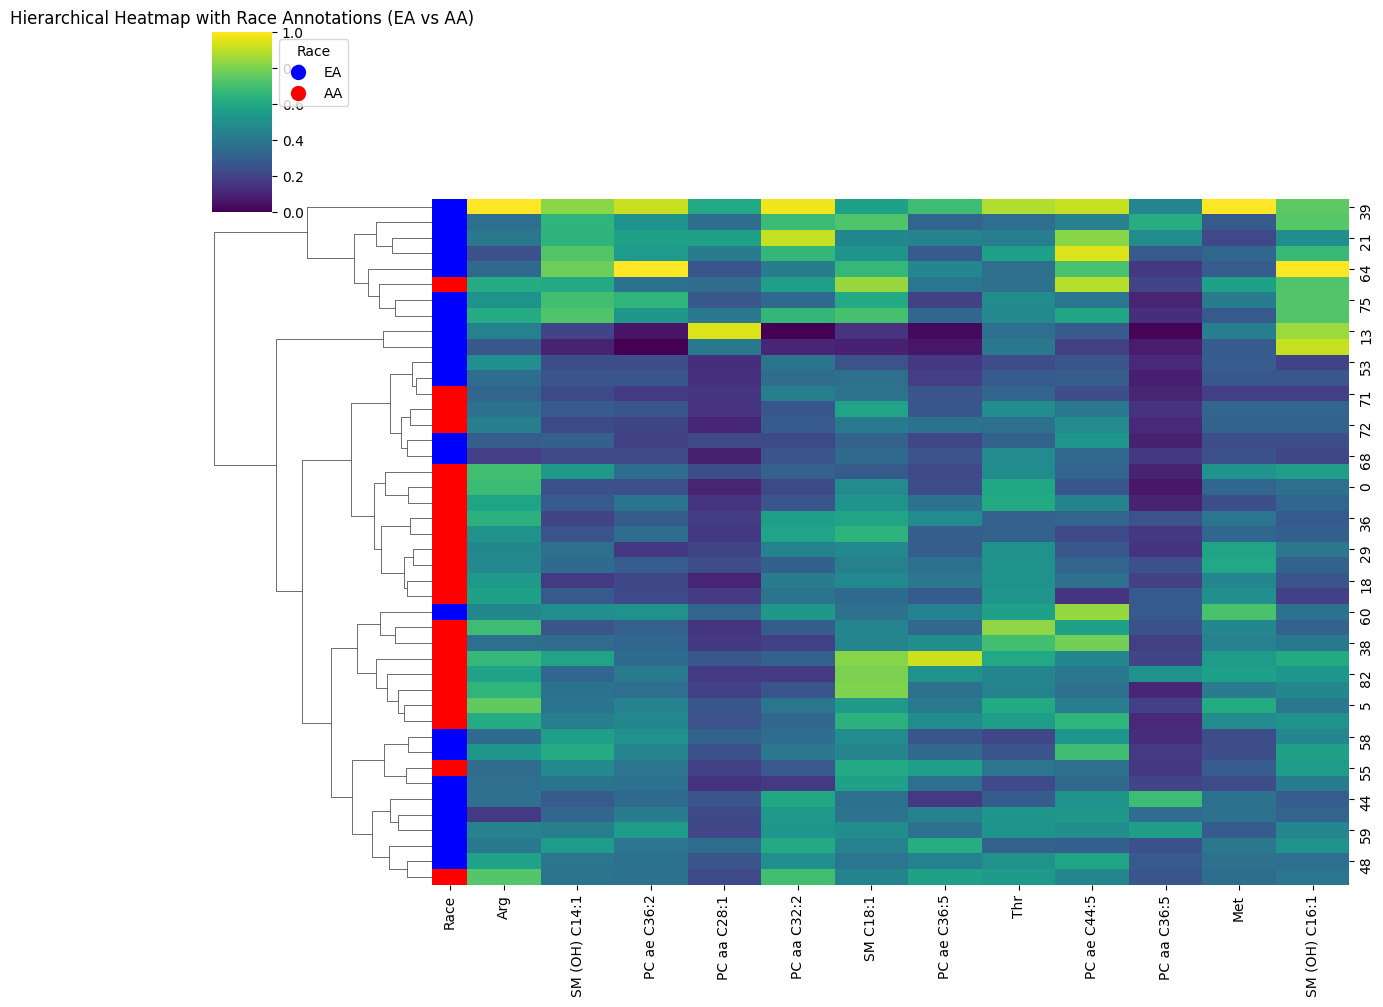

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `top_11_features_lime_df` is your dataframe
df = top_11_features_lime_df

# Map 'Race' values to class names
df['Race'] = df['Race'].map({0: 'EA', 1: 'AA'})

# Extract the 'Race' column
race_labels = df['Race']

# Map the 'Race' classes to colors
lut = {'EA': 'blue', 'AA': 'red'}  # Customize colors as needed
row_colors = race_labels.map(lut)

# Drop the 'Race' column for clustering
numeric_df = df.drop(columns=['Race'])

# Create a hierarchical heatmap with row annotations
sns.clustermap(
    numeric_df,
    metric="euclidean",
    method="ward",
    cmap="viridis",
    figsize=(12, 10),
    col_cluster=False,  # Optional: Disable column clustering
    row_colors=row_colors,  # Add row color annotations for Race
)

# Add a legend for the Race classes
for label, color in lut.items():
    plt.plot([], [], marker="o", ms=10, ls="", mec=None, color=color, label=label)
plt.legend(title="Race", bbox_to_anchor=(1, 1), loc="upper left")

plt.title("Hierarchical Heatmap with Race Annotations (EA vs AA)")
plt.show()


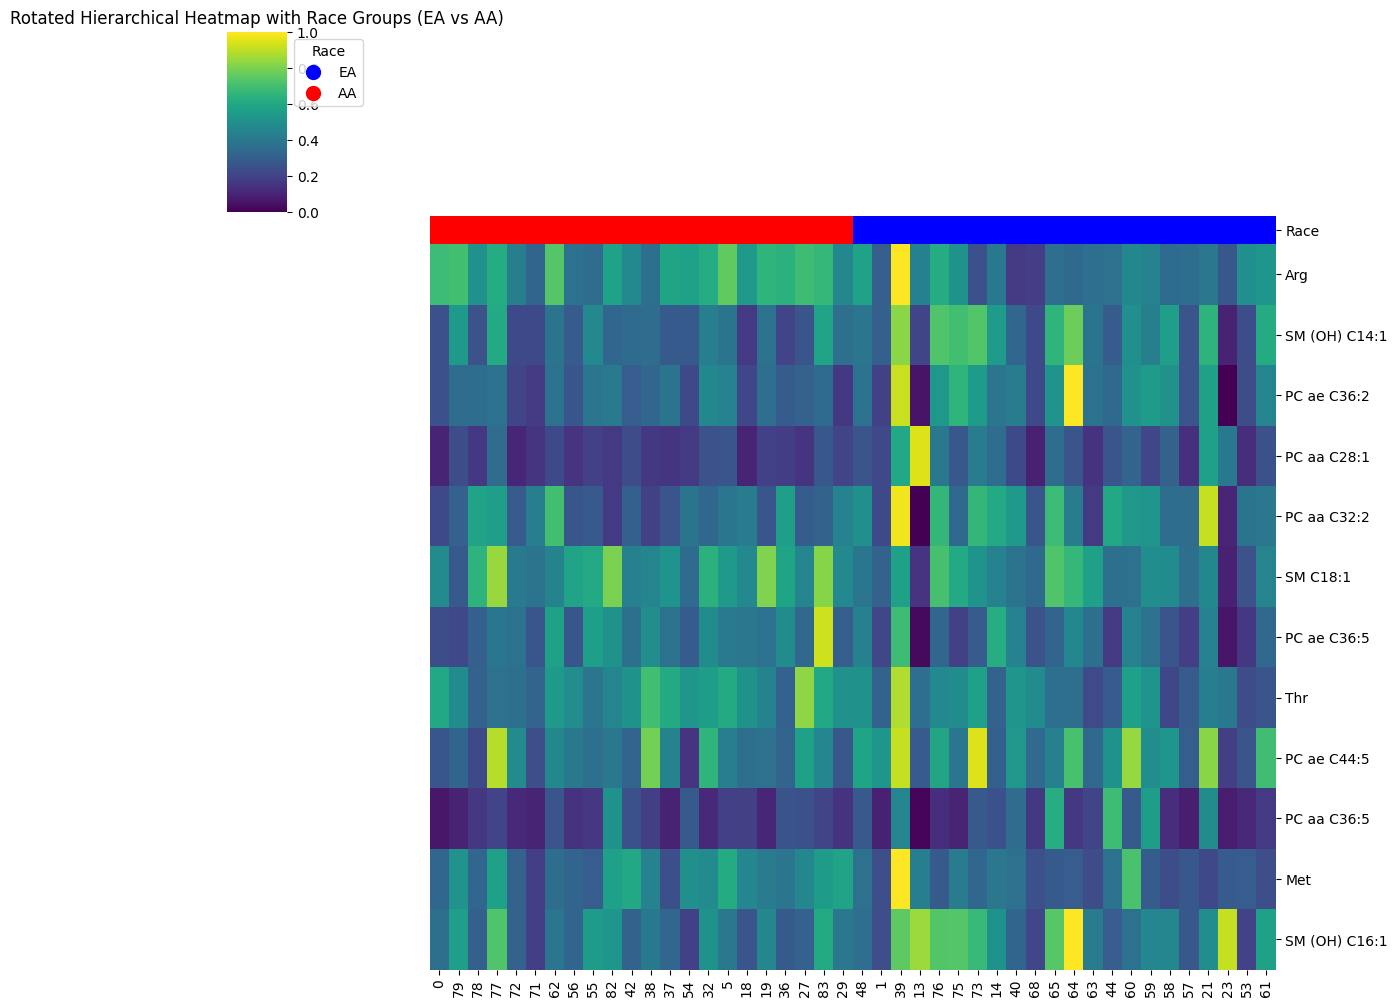

In [29]:
# Sort the dataframe by Race so that EA and AA are grouped
sorted_df = top_11_features_lime_df.sort_values(by="Race")

# Extract the sorted Race column and map to colors
sorted_race_labels = sorted_df["Race"]
col_colors = sorted_race_labels.map(lut)  # Now corresponds to columns instead of rows

# Drop the Race column for clustering
sorted_numeric_df = sorted_df.drop(columns=["Race"])

# Transpose the dataframe to rotate the heatmap
transposed_df = sorted_numeric_df.T

# Create the heatmap with transposed data
sns.clustermap(
    transposed_df,
    metric="euclidean",
    method="ward",  # Optional: Clustering within groups
    cmap="viridis",
    figsize=(12, 10),
    col_cluster=False,  # Disable column clustering to preserve separation
    row_cluster=False,  # Disable row clustering
    col_colors=col_colors,  # Now this annotates columns (Race)
)

# Add a legend for the Race classes
for label, color in lut.items():
    plt.plot([], [], marker="o", ms=10, ls="", mec=None, color=color, label=label)
plt.legend(title="Race", bbox_to_anchor=(1, 1), loc="upper left")

plt.title("Rotated Hierarchical Heatmap with Race Groups (EA vs AA)")
plt.show()


#Box plot

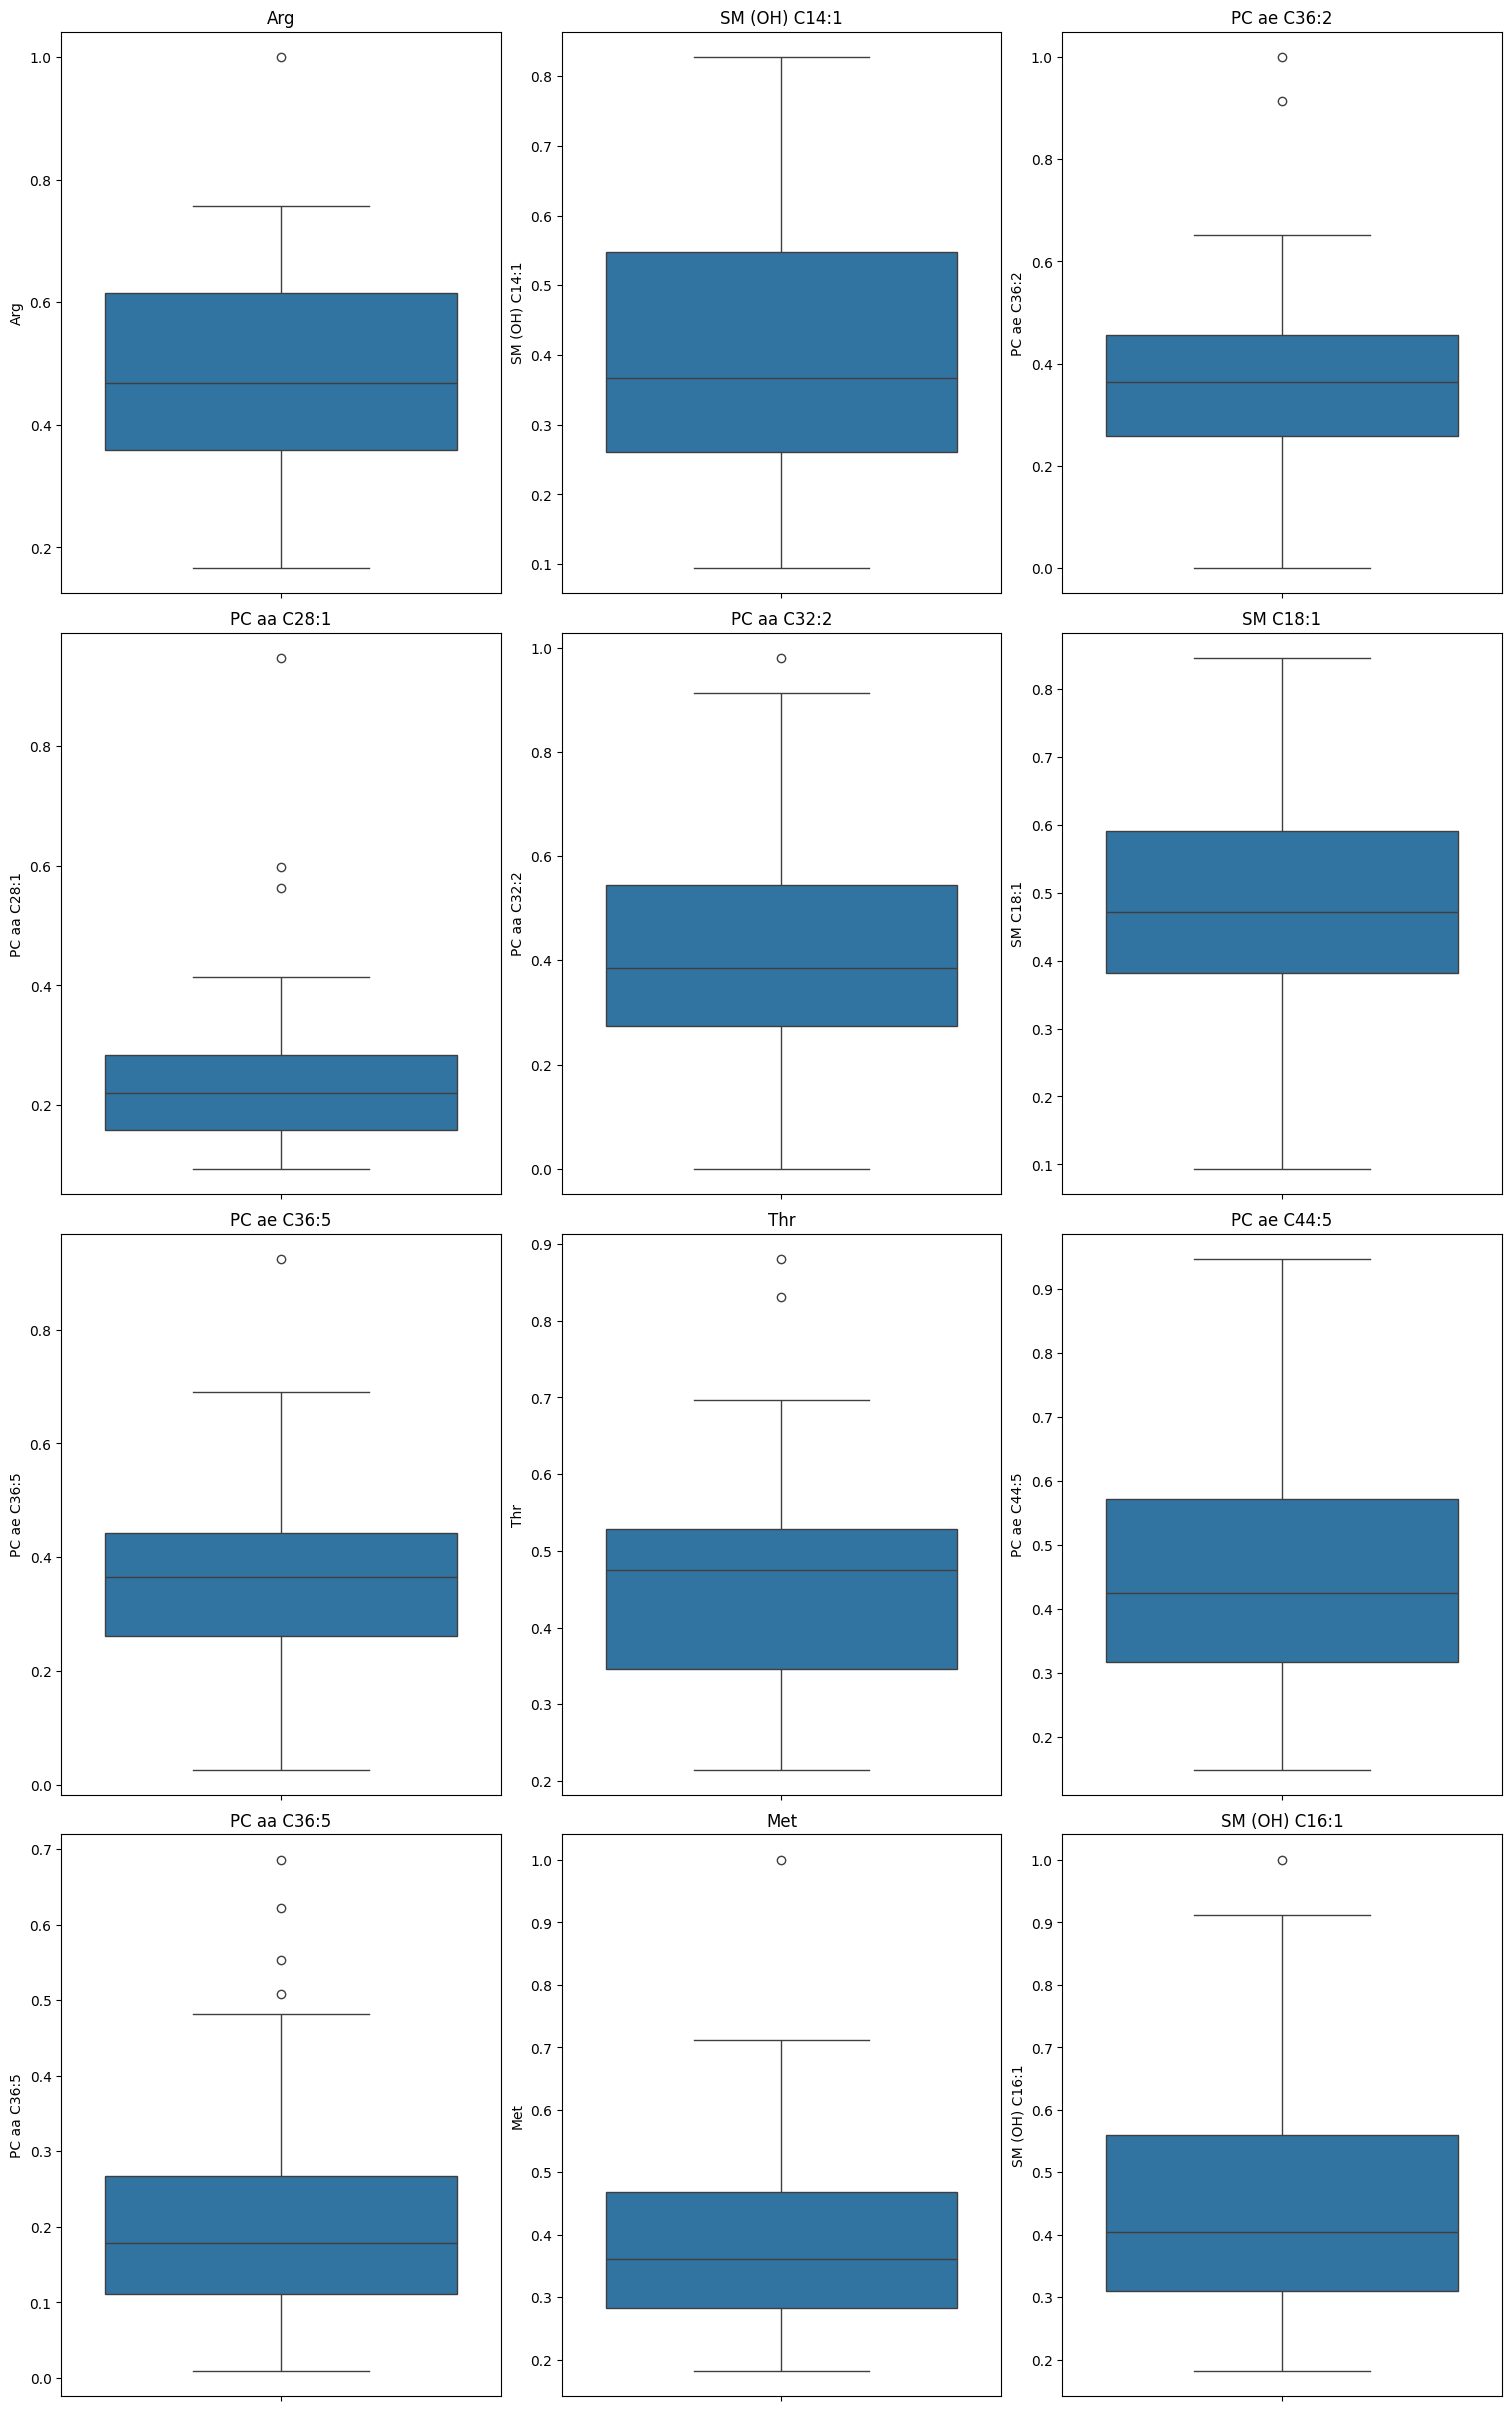

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_to_plot = top_11_features_lime_df.drop(columns=['Race'])

# Create subplots to display boxplots for all columns
num_columns = data_to_plot.shape[1]
fig, axes = plt.subplots(nrows=(num_columns + 2) // 3, ncols=3, figsize=(15, num_columns * 2), constrained_layout=True)

# Flatten axes for easy iteration if it's a 2D array
axes = axes.flatten()

for idx, column in enumerate(data_to_plot.columns):
    sns.boxplot(data=data_to_plot[column], ax=axes[idx])
    axes[idx].set_title(column)

# Remove extra subplots if any
for idx in range(len(data_to_plot.columns), len(axes)):
    fig.delaxes(axes[idx])

# Show the plot
plt.show()


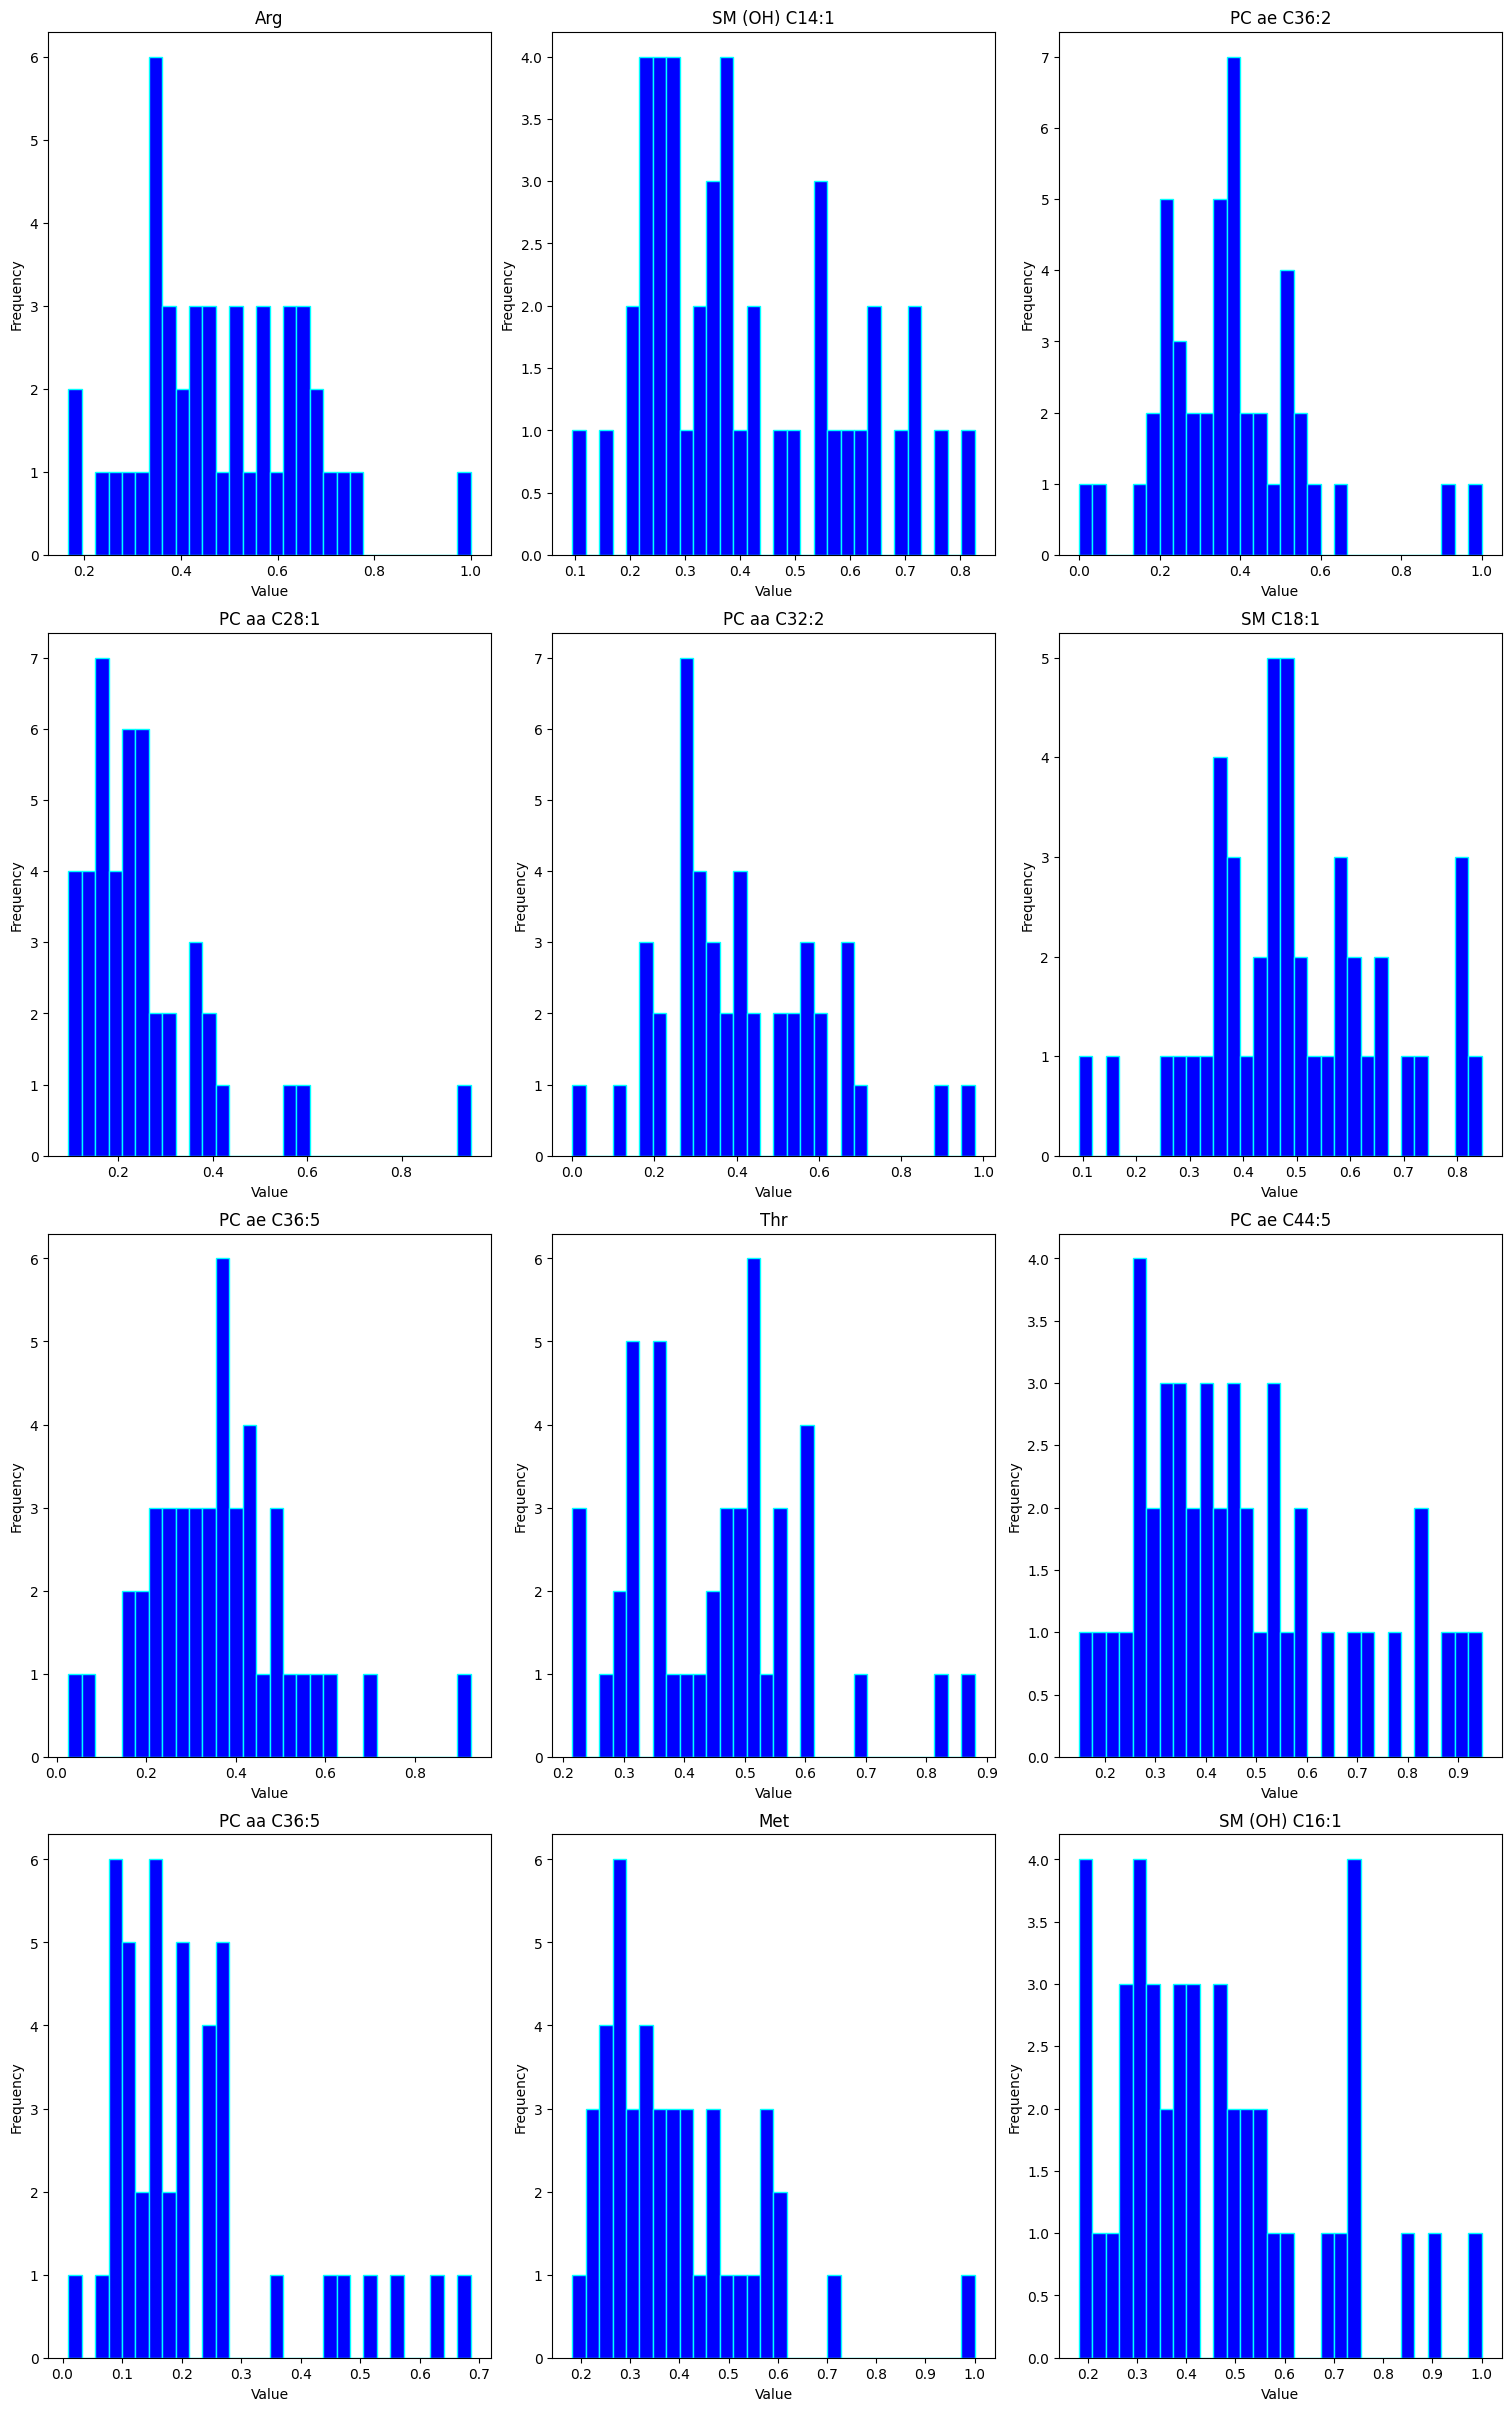

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

data_to_plot = top_11_features_lime_df.drop(columns=['Race'])

# Number of features
num_columns = data_to_plot.shape[1]

# Create subplots to display histograms for all columns
fig, axes = plt.subplots(nrows=(num_columns + 2) // 3, ncols=3, figsize=(15, num_columns * 2), constrained_layout=True)

# Flatten axes for easy iteration if it's a 2D array
axes = axes.flatten()

for idx, column in enumerate(data_to_plot.columns):
    axes[idx].hist(data_to_plot[column].dropna(), bins=30, color='blue', edgecolor='cyan')
    axes[idx].set_title(column)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

# Remove extra subplots if any
for idx in range(len(data_to_plot.columns), len(axes)):
    fig.delaxes(axes[idx])

# Show the plot
plt.show()


Skewness of each feature:
Arg              0.487760
SM (OH) C14:1    0.609785
PC ae C36:2      1.154083
PC aa C28:1      2.501240
PC aa C32:2      0.709501
SM C18:1         0.122666
PC ae C36:5      0.846083
Thr              0.673519
PC ae C44:5      0.797877
PC aa C36:5      1.492874
Met              1.567154
SM (OH) C16:1    0.840156
dtype: float64


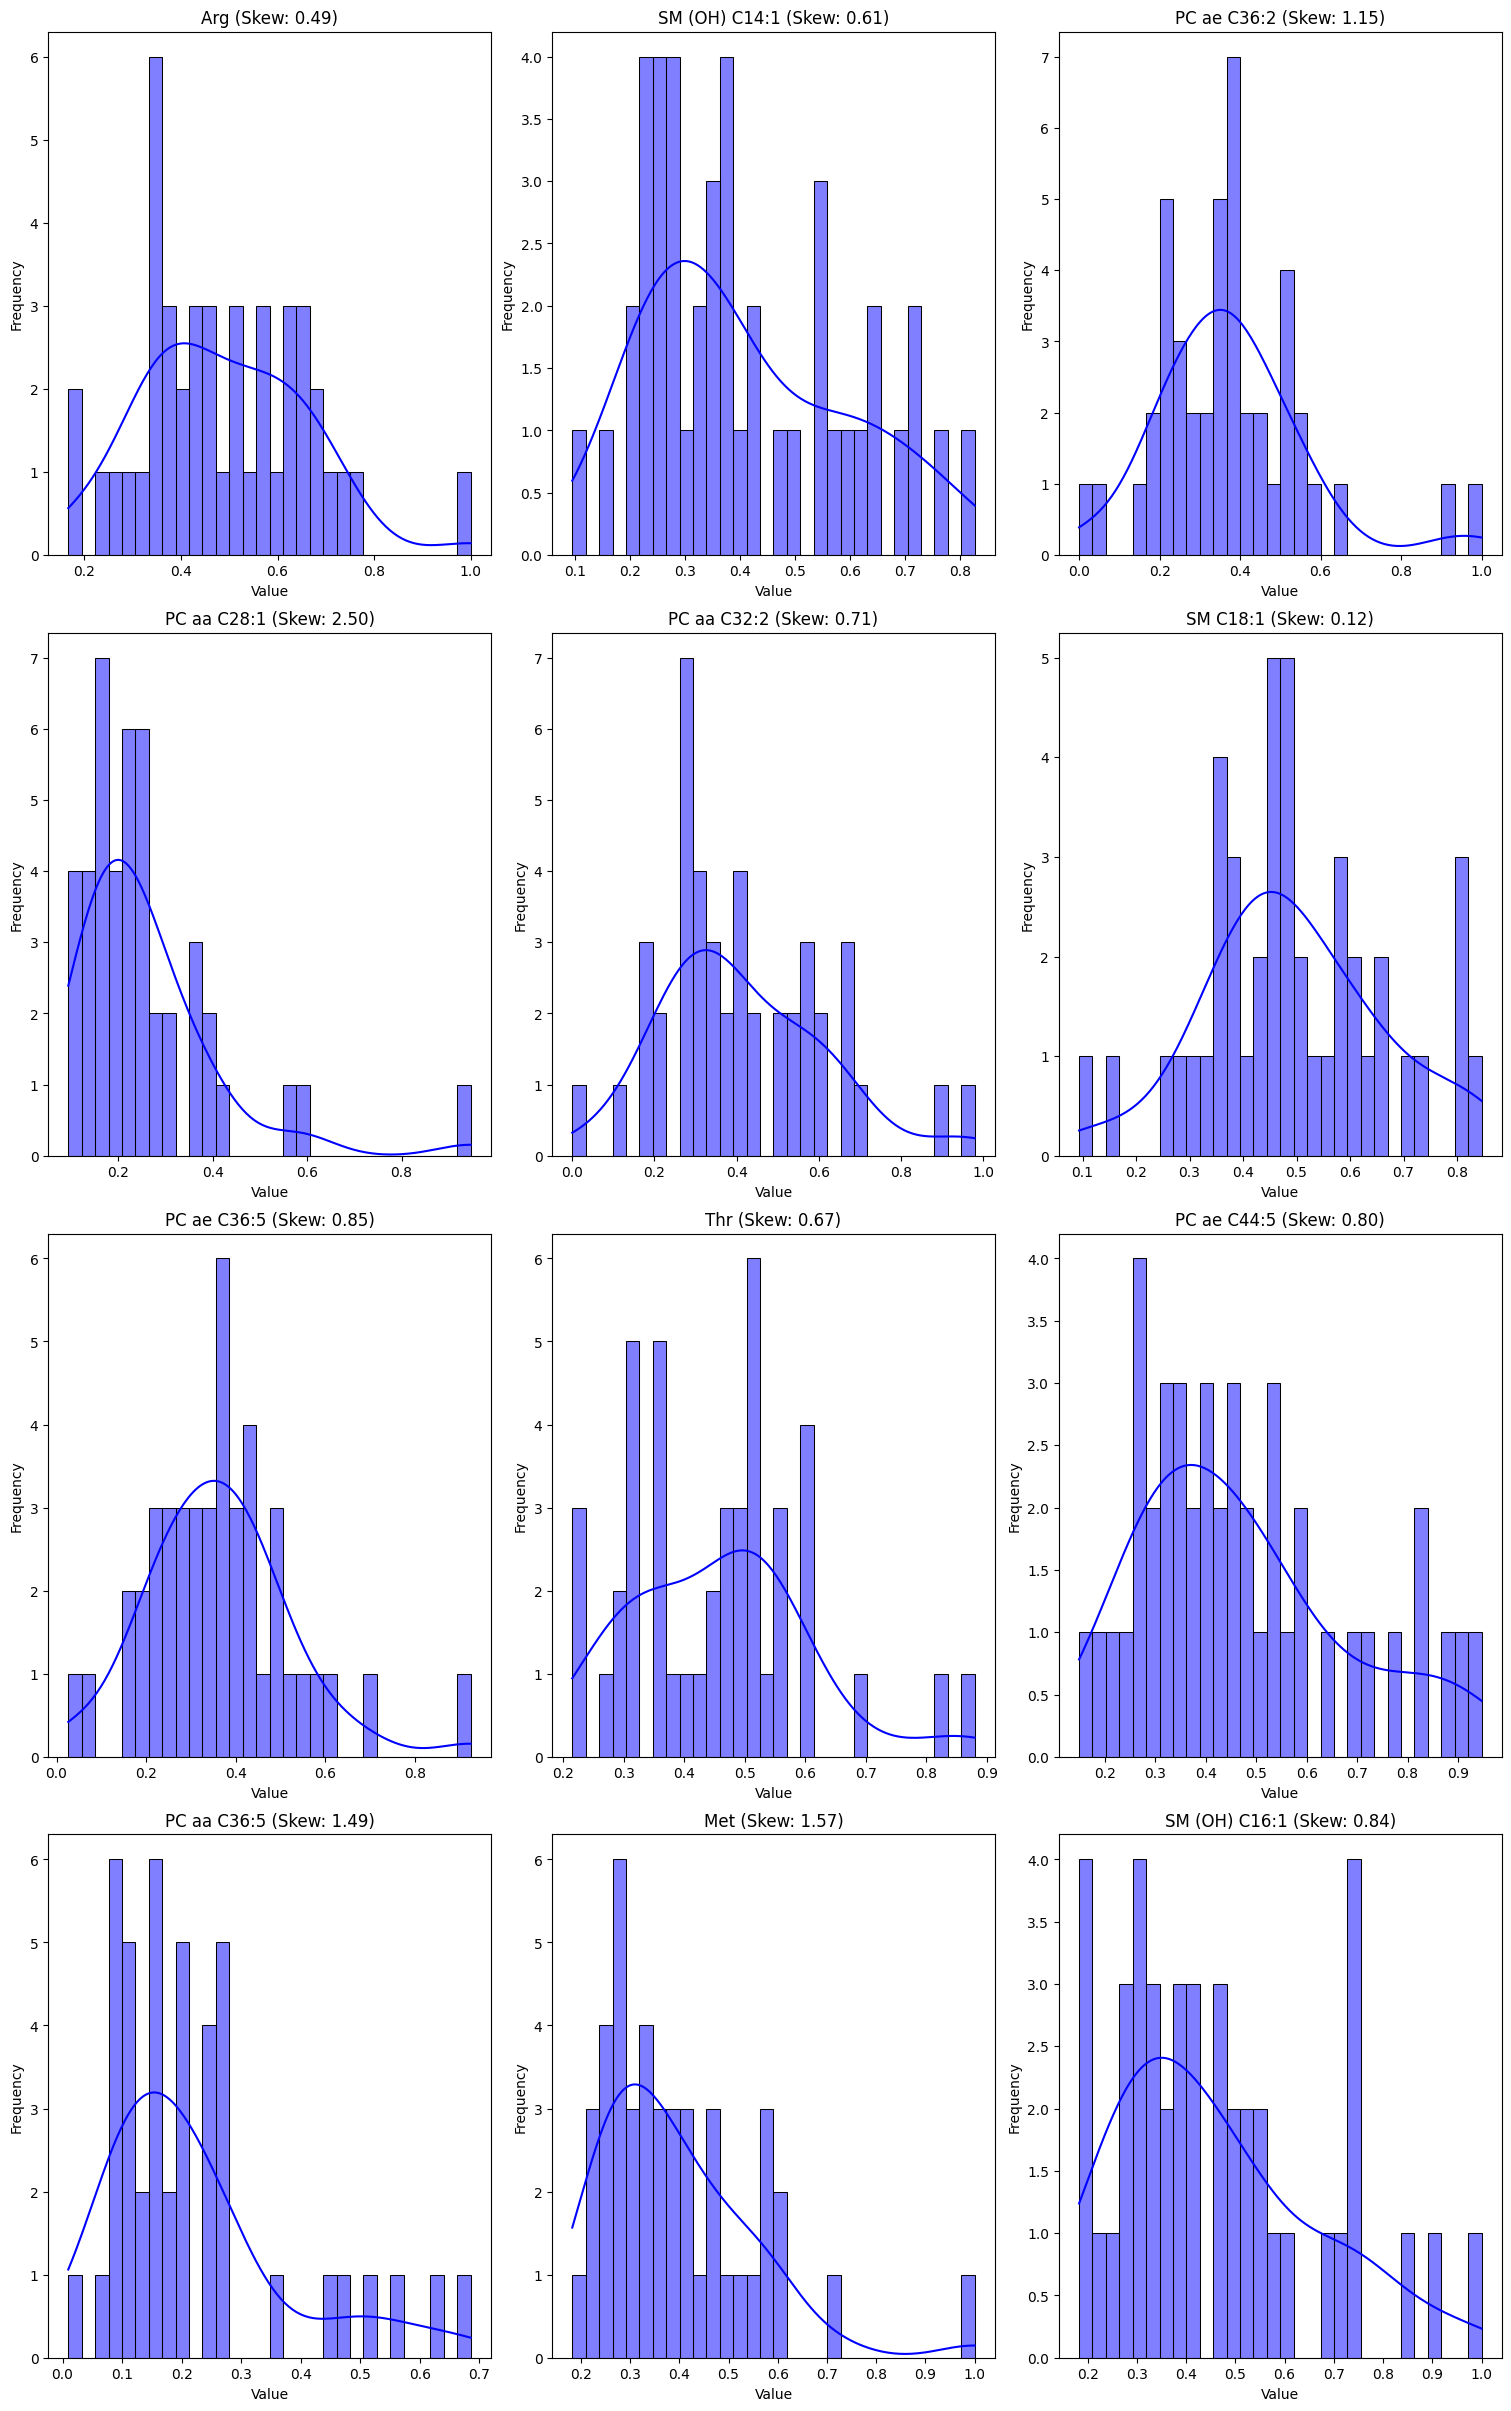

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_to_plot = top_11_features_lime_df.drop(columns=['Race'])

# Calculate skewness for each feature
skewness = data_to_plot.skew()

# Print skewness for each feature
print("Skewness of each feature:")
print(skewness)

# Number of features
num_columns = data_to_plot.shape[1]

# Create subplots to display histograms with KDE (bell curve) for all columns
fig, axes = plt.subplots(nrows=(num_columns + 2) // 3, ncols=3, figsize=(15, num_columns * 2), constrained_layout=True)

# Flatten axes for easy iteration if it's a 2D array
axes = axes.flatten()

for idx, column in enumerate(data_to_plot.columns):
    # Plot histogram and KDE
    sns.histplot(data_to_plot[column], kde=True, bins=30, ax=axes[idx], color='blue', edgecolor='black')

    # Add skewness value to the title
    axes[idx].set_title(f"{column} (Skew: {skewness[column]:.2f})")
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

# Remove extra subplots if any
for idx in range(len(data_to_plot.columns), len(axes)):
    fig.delaxes(axes[idx])

# Show the plot
plt.show()
